# SBRCT Microarray Data
Gene expression arrays are an important new technology in biology. The data for this example form a matrix of 2308 genes (columns) and 63 samples (rows), from a set of microarray experiments. Each expression value is a log-ratio $log(R/G)$. $R$ is the amount of gene-specific RNA in the target sample that hybridizes to a particular (gene-specific) spot on the microarray, and $G$ is the corresponding amount of RNA from a reference sample. The samples arose from small, round blue-cell tumors (SRBCT) found in children, and are classified into four major types: BL (Burkitt lymphoma), EWS (Ewing's sarcoma), NB (neurablastoma), and RMS (rhabdomyosarcoma). There is an additional test data set of 20 observations.
SBRCT gene expression data.

Cancer classes are labelled 1,2,3,4 for c("EWS","RMS","NB","BL")

Diagnosis of multiple cancer types by shrunkencentroids of gene expression
Robert Tibshirani†‡, Trevor Hastie§, Balasubramanian Narasimhan§, and Gilbert Chu¶
https://www.pnas.org/content/pnas/99/10/6567.full.pdf

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, GRAY8, PURPLE = '#231F20', '#646369', '#A6A6A5', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data

In [25]:
data = np.load('../data/srbct.npy.npz')['data']

# last column contains 'is train' flag
is_train = data[:,-1].astype(int)
data_test = data[is_train == 0, :]
data_train = data[is_train == 1, :]
# pre-last column contains class
y_train = data_train[:, -2].astype(int)
y_test = data_test[:, -2].astype(int)
X_train = data_train[:, :-2]
X_test = data_test[:, :-2]
# make labels starting from zero
y_train -= 1
y_test -= 1

## Nearest Shrunken Centroids

In [26]:
stratified_kfolds = StratifiedKFold(8, random_state=1)
nearest_centroid_classifier = Pipeline([
    ('scale', StandardScaler()),
    ('ncc', NearestCentroid())]
)
shrink_threshold_grid_search = GridSearchCV(
    nearest_centroid_classifier,
    {'ncc__shrink_threshold': np.linspace(0, 100, 100)},
    cv=stratified_kfolds,
    iid=True
).fit(X_train, y_train)
best_model = shrink_threshold_grid_search.best_estimator_
print(np.sum(y_test != best_model.predict(X_test)))

0


In [32]:
centroids = best_model[1].centroids_
a = centroids[0, :]
np.sum(np.all(a == centroids, axis = 0))
#centroids[0, :] == centroids[1, :] == centroids[2, :] == centroids[3, :]
#A = ~np.isclose(best_model[1].centroids_, 0)

1901

In [5]:
np.argwhere(np.sum(A, axis=0) > 0).shape

(407, 1)

In [6]:
overall_centroid = np.mean(X_train, axis=0)
relative_class_centroids = [
    np.mean(X_train[y_train == i, :], axis=0) - overall_centroid
    for i in range(4)]

Text(1.2,-300,'Centroids: Average Expression Centered at Overall Centroid')

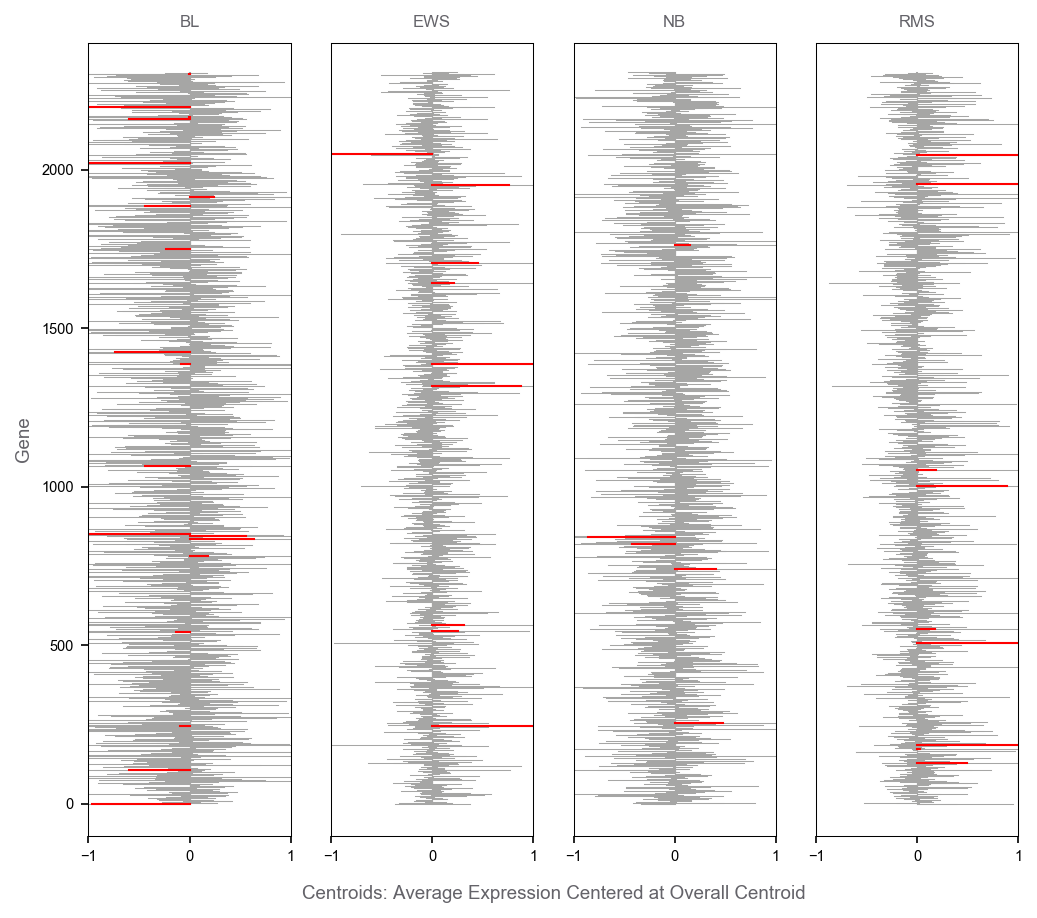

In [116]:
def plot_means(ax, means, d_shrunken, title, hide_y_labels=True):
    for i in range(means.shape[0]):
        ax.plot([0, means[i]], [i, i], linewidth=0.5, color=GRAY8)
    for i in range(d_shrunken.shape[0]):
        if d_shrunken[i] == 0:
            continue
        ax.plot([0, d_shrunken[i]], [i, i], linewidth=1, color='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-100, 2400)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)
    if hide_y_labels:
        ax.tick_params(labelleft=False, left=False)
    else:
        ax.set_ylabel('Gene', color=GRAY4, fontsize=9)
    ax.text(0, 2450, title, color=GRAY4, fontsize=8,
                horizontalalignment='center')        

fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8, 7), dpi=150)
plot_means(axarr[0], relative_class_centroids[0], d_shrunken[0], 'BL', False)
plot_means(axarr[1], relative_class_centroids[1], d_shrunken[1], 'EWS')
plot_means(axarr[2], relative_class_centroids[2], d_shrunken[2], 'NB')
plot_means(axarr[3], relative_class_centroids[3], d_shrunken[3], 'RMS')
axarr[1].text(1.2, -300, 'Centroids: Average Expression Centered at Overall Centroid',
              color=GRAY4, fontsize=9, horizontalalignment='center')

In [49]:
p, n, K = X_train.shape[1], y_train.shape[0], 4

_, class_counts = np.unique(y_train, return_counts=True)
priors = class_counts / n
m = [(1/nk + 1/n)**0.5 for nk in class_counts]
class_centroids = [np.mean(X_train[y_train == i, :], axis=0) for i in range(K)]

In [50]:
s_squared = np.zeros(shape=p)
for k in range(K):
    s_squared += np.sum((X_train[y_train == k, :] - class_centroids[k])**2, axis=0)
s_squared /= (n - K)
s = s_squared**0.5
s0 = np.median(s)
d = [(class_centroids[k] - overall_centroid)/(m[k]*(s + s0)) for k in range(K)]

In [112]:
delta = 3.6
d_shrunken = [np.sign(d[k])*(np.abs(d[k])-delta).clip(0) for k in range(K)]
class_centroids_shrunken = [overall_centroid + m[k]*(s + s0)*d_shrunken[k] for k in range(K)]

In [113]:
#sum(np.sum(d_shrunken[i] != 0) for i in range(K))
for i in range(y_test.shape[0]):
    sigma = np.array([-np.sum((X_test[i] - class_centroids_shrunken[k])**2 / s_squared) + 2 * np.log(priors[k]) for k in range(K)])
    y_hat = np.argmax(sigma)
    print(y_hat, y_test[i])

2 2
1 1
3 3
1 1
0 0
2 2
3 3
1 1
2 2
0 0
2 2
3 3
0 0
1 1
1 1
1 1
3 3
2 2
3 3
2 2


In [114]:
sum(np.sum(d_shrunken[k] != 0) for k in range(K))

43

In [115]:
d_shrunken[0]

array([-0.96366135, -0.        ,  0.        , ..., -0.        ,
        0.        , -0.        ])